# 04 Unequal Length

I train the LSTM on all strings of length $\le k$, test the LSTM on all strings of length $>k, \le 2k$ and then gradually increase $k$ from 16 to 128. I just changed the data generation, so everything else should be the same.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/CS281\ Final\ Project

## Package Loading

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from sklearn.model_selection import train_test_split
device = 'cuda'

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Model Definition

In [0]:
class Counter():
    def __init__(self, hidden):
        '''hidden is the number of hidden variables to use per cell'''

        #this LSTM goes from input [batch x length x 1] to output [batch x length x hidden]
        self.lstm = nn.LSTM(1, hidden, batch_first=True).double().cuda() 

        #this matrix transforms from [1 x hidden] to [1 x 1]
        self.combine = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 

        params = list(self.lstm.parameters())
        params.append(self.combine)
        self.optimizer = optim.Adam(params)

    @staticmethod
    def convert_sequence(seq):
        '''converts a set of sequences with the same length from array or numpy into a correctly formatted tensor.
        Shape: [batch x length x 1]'''
        seq = torch.tensor(seq, device=device).double()
        seq = seq.reshape([len(seq), -1, 1])
        return seq

    def predict(self, sequence):
        '''takes a tensor, predicts the sum of the tensor, and compares to the actual sum of the tensor. 
        Returns the loss and the predicted sum'''
        pred, _ = self.lstm(sequence)
        pred = pred[:,-1,:] @ self.combine 
        #the second index is the rolling output. The final output is the last element in that index

        loss = (pred - sequence.sum(1)).pow(2)
        return loss, pred

    def predict_multilength(self, sequences):
        '''Takes a list of batches of tensors of different length. Predicts on each batch. Sums up the loss. Reduces to a single mean'''
        loss = torch.tensor(0, device=device).double()
        count= torch.tensor(0, device=device).double()
        for s in sequences:
            pred = self.predict(s)[0]
            count += pred.shape[0]
            loss += pred.sum()
        return loss / count

## Model Testing

In [0]:
def generate_data(length, total):
    counts = np.random.dirichlet(np.arange(length)**2+1) * total * 0.9
    counts = np.round(counts).astype(int)

    train_set = []
    val_set = []
    test_set = []

    for i in range(1,length+1):
        if counts[i-1] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i-1],i])
        seqs = np.unique(seqs, axis=0)
        try:
            train, val = train_test_split(seqs, test_size=2/9, shuffle=True)
            train = Counter.convert_sequence(train)
            val = Counter.convert_sequence(val)
            train_set.append(train)
            val_set.append(val)
        except ValueError:
            continue

    counts = np.random.dirichlet(np.arange(length, 2*length)**2+1) * total * 0.1
    counts = np.round(counts).astype(int)
    for i in range(length):
        if counts[i] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i],i+length+1])
        seqs = np.unique(seqs, axis=0)
        test = Counter.convert_sequence(seqs)
        test_set.append(test)

    trainsize = sum([x.shape[0] for x in train_set])
    valsize = sum([x.shape[0] for x in val_set])
    testsize = sum([x.shape[0] for x in test_set])
    print(trainsize, valsize, testsize)

    total = trainsize+valsize+testsize
    print("Total:",total)
    print("Fraction %.3f %.3f %.3f"%(trainsize/total, valsize/total, testsize/total))
    return train_set, val_set, test_set

In [0]:
train, val, test = generate_data(16,100000)
for x in train:
    print(x.shape)
for x in val:
    print(x.shape)
for x in test:
    print(x.shape)

In [0]:
#generate all the strings and partition into train and test
length = 16
hidden = 5

print(length)
depth = 100000
train, val, test = generate_data(length,depth)
#train over all the training data
model = Counter(hidden=hidden)

history = []
best = float('inf')
patience = 10
tol = 0.001
count = 0

for epoch in range(1000000): 
    shuffle(train)
    shuffle(val)
    if epoch % 100 == 0:
        train_loss = model.predict_multilength(train).item()
        with torch.no_grad():
            val_loss = model.predict_multilength(val).item()
        history.append([train_loss, val_loss])
        print("Epoch: %5d. Train Loss: %7.3f. Validation Loss: %7.3f"%(epoch, train_loss, val_loss))

        if val_loss + tol < best:
            best = val_loss
            count = 0
        else:
            count += 1
        if count >= patience:
            break

    #take the average loss over all the train data
    loss = model.predict_multilength(train)   
    #and update
    model.optimizer.zero_grad()
    loss.backward(retain_graph=True)
    model.optimizer.step()
history = np.array(history)
np.save("Part-3-Outputs/Train-%d-%d"%(hidden, length), history)
torch.save(model, "Part-3-Outputs/Model-%d-%d"%(hidden, length))

#display testing results
loss = model.predict_multilength(test)
print("Average Test Loss:", loss.item())

with open("Part-3-Outputs/TrainResults.txt", 'a') as f:
    f.write("%3d %9.5f\n"%(length, loss.item()))

with open("Part-3-Outputs/Test-%d-%d.txt"%(hidden, length), 'w') as f:
    for seq in test:
        loss, pred = model.predict(seq)
        for k in range(len(seq)):
            string = seq[k].int().cpu().numpy().flatten()
            f.write("%s -- %d -- %.3f\n"%(str(string), sum(string), pred[k].item()))

print('\n\n\n')

## Results

In [0]:
def ReadOutFile(h, l):
  file_name = 'Part-4-Outputs/Run' + str(h) + '_' + str(l) + '.out'
  s = open(file_name)
  line_num = 0
  epoch, train_loss, val_loss = [], [], []

  for line in s:
    line_num += 1
    if line_num == 2:
      train_num, val_num, test_num = line.split()
      
    elif line_num > 4 and len(line.split()) == 8:
      _, x, _, _, y, _, _, z =  line.split()
      epoch.append(float(x.rstrip('.')))
      train_loss.append(float(y.rstrip('.')))
      val_loss.append(float(z))

    elif line_num > 4 and len(line.split()) == 4:
      _, _, _, avg_test_loss = line.split()
    
  return epoch, train_loss, val_loss, float(avg_test_loss)

def PlotOutFile(h, l):
  epoch, train_loss, val_loss, _ = ReadOutFile(h, l)
  plt.plot(epoch, train_loss, c = 'r', label = 'Training Loss', alpha = 0.7)
  plt.plot(epoch, val_loss,  c = 'b', label = 'Validation Loss', alpha = 0.7)
  plt.title("Hidden Units = " + str(h) + "; Length = " + str(l))
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.legend()
  plt.show()

def PlotMultipleOutFilesConstL(hs, l):
  for h in hs:
    epoch, train_loss, val_loss, _ = ReadOutFile(h, l)
    plt.plot(epoch, val_loss, label = str(h) + ' Hidden Units' , alpha = 0.7)
  plt.xscale('log')
  plt.title("Length = " + str(l))
  plt.xlabel("Epoch")
  plt.ylabel("Validation MSE")
  plt.legend()
  plt.show()
  
def PlotMultipleOutFilesConstH(h, ls):
  for l in ls:
    epoch, train_loss, val_loss, _ = ReadOutFile(h, l)
    plt.plot(epoch, val_loss, label = 'Length = ' + str(l) , alpha = 0.7)
  plt.xscale('log')
  plt.title(str(h) + " Hidden Units")
  plt.xlabel("Epoch")
  plt.ylabel("Validation MSE")
  plt.legend()
  plt.show()

def PlotMultipleOutFilesConstHZoomed(h, ls, print_epoch = 15000):
  for l in ls:
    epoch, train_loss, val_loss, _ = ReadOutFile(h, l)
    choosen_epoch, choosen_val_loss = [], []
    for i in range(len(epoch)):
      if epoch[i] > print_epoch:
        choosen_epoch.append(epoch[i])
        choosen_val_loss.append(val_loss[i])
    plt.plot(choosen_epoch, choosen_val_loss, label = 'Length = ' + str(l) , alpha = 0.7)
  plt.xscale('log')
  plt.title(str(h) + " Hidden Units")
  plt.xlabel("Epoch")
  plt.ylabel("Validation MSE")
  plt.legend()
  plt.show()

def PlotTestErrorConstH(h, ls):
  test_error  = []
  for l in ls:
    _, _, _, avg_test_loss = ReadOutFile(h, l)
    test_error.append(avg_test_loss)
  
  plt.plot(ls, test_error)
  plt.title(str(h) + " Hidden Units")
  plt.xlabel("Length")
  plt.ylabel("Test MSE")
  plt.legend()
  plt.show()

In [0]:
passes = []
fails = []

for h in range(1,8,2):
  for l in range(16,257,16):
    try:
      epoch, train_loss, val_loss, avg_test_loss = ReadOutFile(h,l)
      if avg_test_loss:
        passes.append((h,l,len(epoch), train_loss[-1], val_loss[-1], avg_test_loss))
      else:
        fails.append((h,l,len(epoch), train_loss[-1], val_loss[-1], avg_test_loss))
    except:
      pass

1 80
1 96
1 112
1 128
3 128
5 128
7 112
7 128


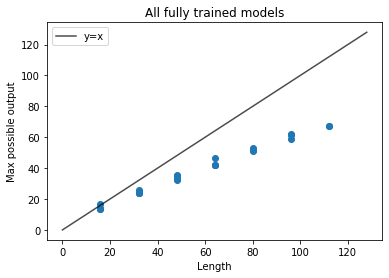

In [0]:
max_possibles = []
ks = []

for h in range(1,8,2):
  for l in range(16,129,16):
    try:
      weights = torch.load('Part-4-Outputs/Model-' + str(h) + '-' + str(l))
      max_possibles += [float(sum(abs(weights.combine)))]
      ks += [l]
    except:
      print(h,l)
      continue

plt.plot(np.linspace(0,128), np.linspace(0,128), color='k',label='y=x', alpha=0.7)

plt.scatter(ks,max_possibles)
plt.title("All fully trained models")
plt.xlabel("Length")
plt.ylabel("Max possible output")
plt.legend()
plt.show()

In [0]:
def PlotMultipleOutFilesConstLZoomed(hs, l, print_epochs, xscale='log'):
  for h in hs:
    epoch, train_loss, val_loss, _ = ReadOutFile(h, l)
    choosen_epoch, choosen_val_loss = [], []
    for i in range(len(epoch)):
      if epoch[i] in print_epochs:
        choosen_epoch.append(epoch[i])
        choosen_val_loss.append(val_loss[i])
    plt.plot(choosen_epoch, choosen_val_loss, label = str(h) + ' Hidden Units'  , alpha = 0.7)
  plt.xscale(xscale)
  plt.title("Length = " + str(l))
  plt.xlabel("Epoch")
  plt.ylabel("Validation MSE")
  plt.legend()
  plt.show()